# An√°lise de Performance do Servidor Online Boutique

Este notebook analisa a performance do servidor durante um teste de carga de 10 segundos com 200 usu√°rios simult√¢neos.

## M√©tricas Analisadas:
- **Lat√™ncia**: Tempo de resposta das requisi√ß√µes
- **Throughput**: Requisi√ß√µes por segundo
- **Uso de CPU**: Consumo de recursos do servidor
- **Escalabilidade**: M√°ximo de r√©plicas do HPA (Horizontal Pod Autoscaler)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configura√ß√£o do estilo dos gr√°ficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


## 1. Carregamento dos Dados


In [ ]:
# Carregar dados do Locust
locust_stats = pd.read_csv('load-testing/results/monolith_run_stats.csv')
locust_history = pd.read_csv('load-testing/results/monolith_run_stats_history.csv')

# Carregar dados de m√©tricas do servidor
hpa_max = pd.read_csv('monolith/hpa_max.csv')
hpa_current = pd.read_csv('monolith/hpa_current.csv')
hpa_desired = pd.read_csv('monolith/hpa_desired.csv')
cpu_pod = pd.read_csv('monolith/cpu_pod_long.csv')

print("Dados carregados com sucesso!")
print(f"Locust Stats: {len(locust_stats)} linhas")
print(f"Locust History: {len(locust_history)} linhas")
print(f"HPA Max: {len(hpa_max)} linhas")
print(f"HPA Current: {len(hpa_current)} linhas")
print(f"HPA Desired: {len(hpa_desired)} linhas")
print(f"CPU Pod: {len(cpu_pod)} linhas")


Dados carregados com sucesso!
Locust Stats: 12 linhas
Locust History: 296 linhas
HPA Max: 22 linhas
HPA Current: 22 linhas
HPA Desired: 22 linhas
CPU Pod: 22 linhas


## 2. An√°lise de Lat√™ncia


=== M√âTRICAS DE LAT√äNCIA ===
      M√©trica  Tempo (ms)
Mediana (50%)   11.000000
        M√©dia   13.686326
          P95   23.000000
          P99  100.000000
       M√°ximo  239.105800


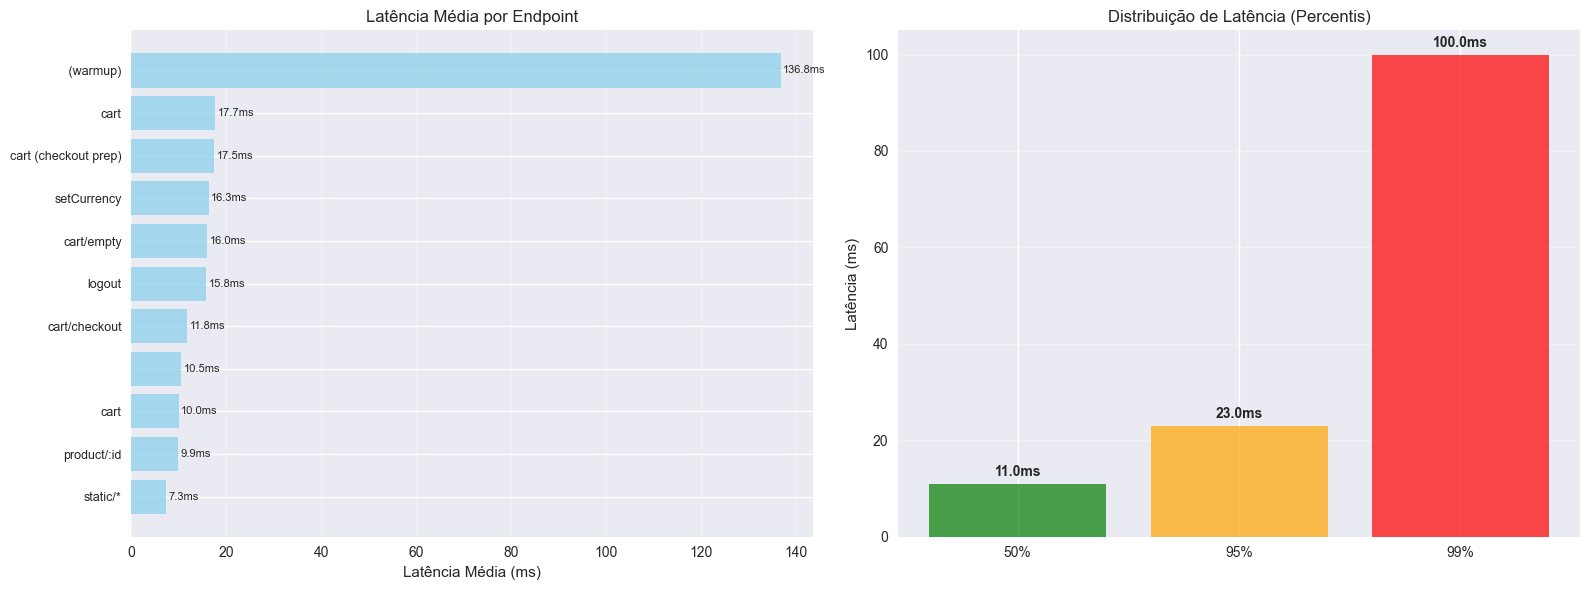

In [11]:
# Filtrar apenas dados agregados do Locust
aggregated_stats = locust_stats[locust_stats['Type'].isna() | (locust_stats['Type'] == '')]

# Extrair m√©tricas de lat√™ncia
latency_metrics = {
    'M√©trica': ['Mediana (50%)', 'M√©dia', 'P95', 'P99', 'M√°ximo'],
    'Tempo (ms)': [
        aggregated_stats['Median Response Time'].iloc[0],
        aggregated_stats['Average Response Time'].iloc[0],
        aggregated_stats['95%'].iloc[0],
        aggregated_stats['99%'].iloc[0],
        aggregated_stats['Max Response Time'].iloc[0]
    ]
}

latency_df = pd.DataFrame(latency_metrics)
print("=== M√âTRICAS DE LAT√äNCIA ===")
print(latency_df.to_string(index=False))

# Gr√°fico de lat√™ncia por endpoint
endpoint_stats = locust_stats[locust_stats['Type'].notna() & (locust_stats['Type'] != '')]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gr√°fico 1: Lat√™ncia m√©dia por endpoint
endpoint_latency = endpoint_stats.groupby('Name')['Average Response Time'].mean().sort_values(ascending=True)
bars1 = ax1.barh(range(len(endpoint_latency)), endpoint_latency.values, color='skyblue', alpha=0.7)
ax1.set_yticks(range(len(endpoint_latency)))
ax1.set_yticklabels([name.replace('GET /', '').replace('POST /', '') for name in endpoint_latency.index], fontsize=9)
ax1.set_xlabel('Lat√™ncia M√©dia (ms)')
ax1.set_title('Lat√™ncia M√©dia por Endpoint')
ax1.grid(axis='x', alpha=0.3)

# Adicionar valores nas barras
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width:.1f}ms', 
             ha='left', va='center', fontsize=8)

# Gr√°fico 2: Distribui√ß√£o de lat√™ncia (P50, P95, P99)
percentiles = ['50%', '95%', '99%']
percentile_values = [aggregated_stats['50%'].iloc[0], aggregated_stats['95%'].iloc[0], aggregated_stats['99%'].iloc[0]]

bars2 = ax2.bar(percentiles, percentile_values, color=['green', 'orange', 'red'], alpha=0.7)
ax2.set_ylabel('Lat√™ncia (ms)')
ax2.set_title('Distribui√ß√£o de Lat√™ncia (Percentis)')
ax2.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for bar, value in zip(bars2, percentile_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 1, f'{value:.1f}ms', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


## 3. An√°lise de Throughput


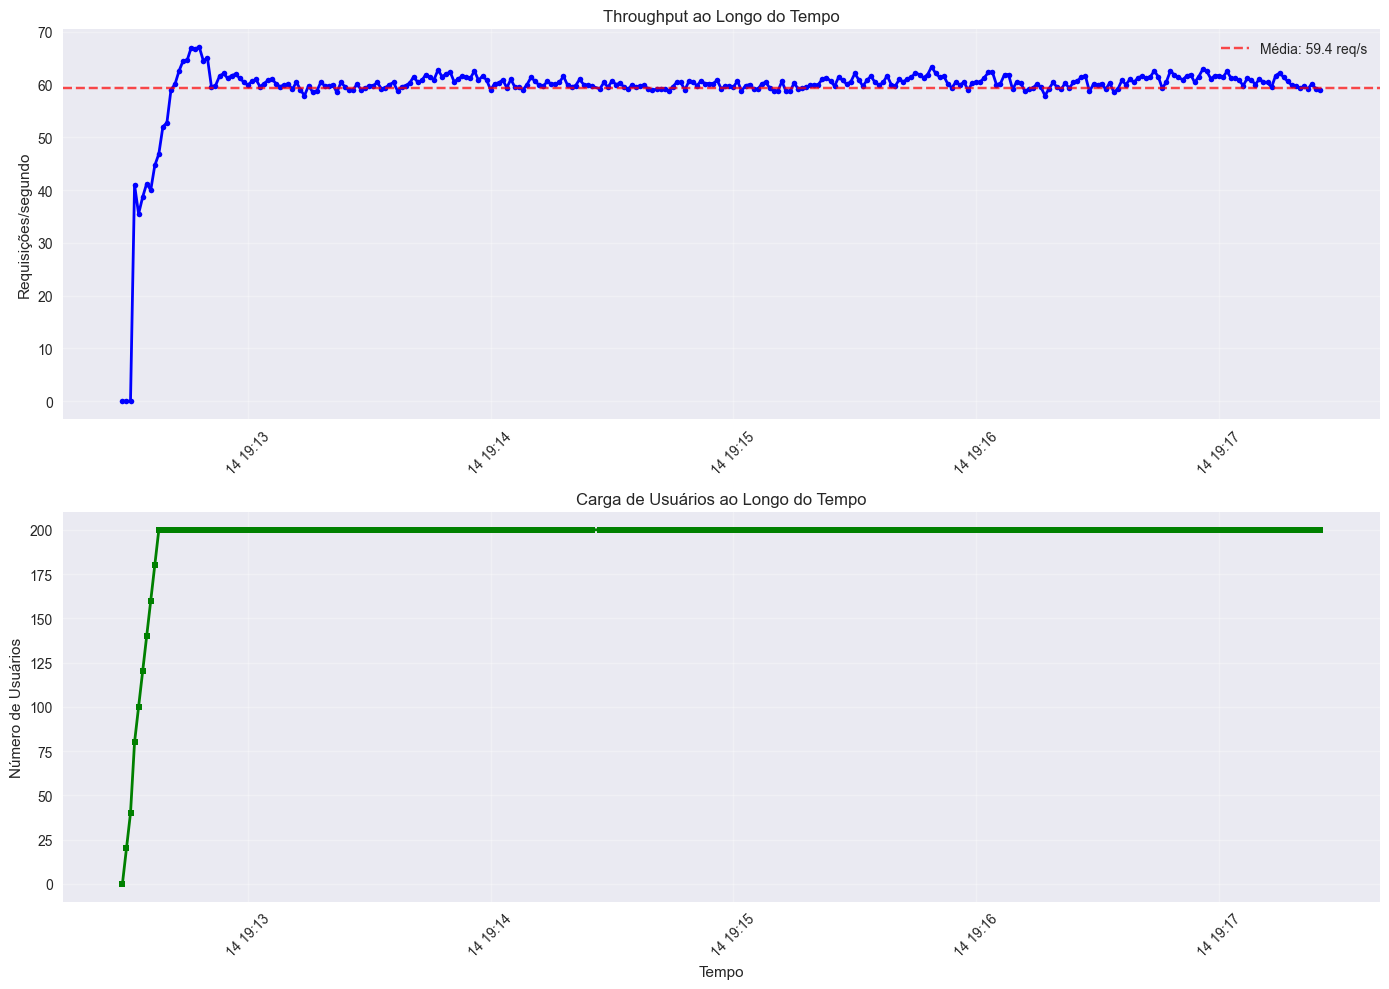

=== ESTAT√çSTICAS DE THROUGHPUT ===
Throughput M√©dio: 59.35 req/s
Throughput M√°ximo: 67.10 req/s
Throughput M√≠nimo: 0.00 req/s
Desvio Padr√£o: 6.87 req/s


In [12]:
# Converter timestamp para datetime
locust_history['datetime'] = pd.to_datetime(locust_history['Timestamp'], unit='s')
hpa_max['datetime'] = pd.to_datetime(hpa_max['timestamp'], unit='s')
hpa_current['datetime'] = pd.to_datetime(hpa_current['timestamp'], unit='s')
hpa_desired['datetime'] = pd.to_datetime(hpa_desired['timestamp'], unit='s')
cpu_pod['datetime'] = pd.to_datetime(cpu_pod['timestamp'], unit='s')

# Filtrar apenas dados agregados do hist√≥rico
history_aggregated = locust_history[locust_history['Type'].isna() | (locust_history['Type'] == '')]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Gr√°fico 1: Throughput ao longo do tempo
ax1.plot(history_aggregated['datetime'], history_aggregated['Requests/s'], 
         linewidth=2, color='blue', marker='o', markersize=4)
ax1.set_ylabel('Requisi√ß√µes/segundo')
ax1.set_title('Throughput ao Longo do Tempo')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Adicionar linha de m√©dia
avg_throughput = history_aggregated['Requests/s'].mean()
ax1.axhline(y=avg_throughput, color='red', linestyle='--', alpha=0.7, 
           label=f'M√©dia: {avg_throughput:.1f} req/s')
ax1.legend()

# Gr√°fico 2: N√∫mero de usu√°rios ao longo do tempo
ax2.plot(history_aggregated['datetime'], history_aggregated['User Count'], 
         linewidth=2, color='green', marker='s', markersize=4)
ax2.set_ylabel('N√∫mero de Usu√°rios')
ax2.set_xlabel('Tempo')
ax2.set_title('Carga de Usu√°rios ao Longo do Tempo')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Estat√≠sticas de throughput
print("=== ESTAT√çSTICAS DE THROUGHPUT ===")
print(f"Throughput M√©dio: {avg_throughput:.2f} req/s")
print(f"Throughput M√°ximo: {history_aggregated['Requests/s'].max():.2f} req/s")
print(f"Throughput M√≠nimo: {history_aggregated['Requests/s'].min():.2f} req/s")
print(f"Desvio Padr√£o: {history_aggregated['Requests/s'].std():.2f} req/s")


## 4. An√°lise de Uso de CPU


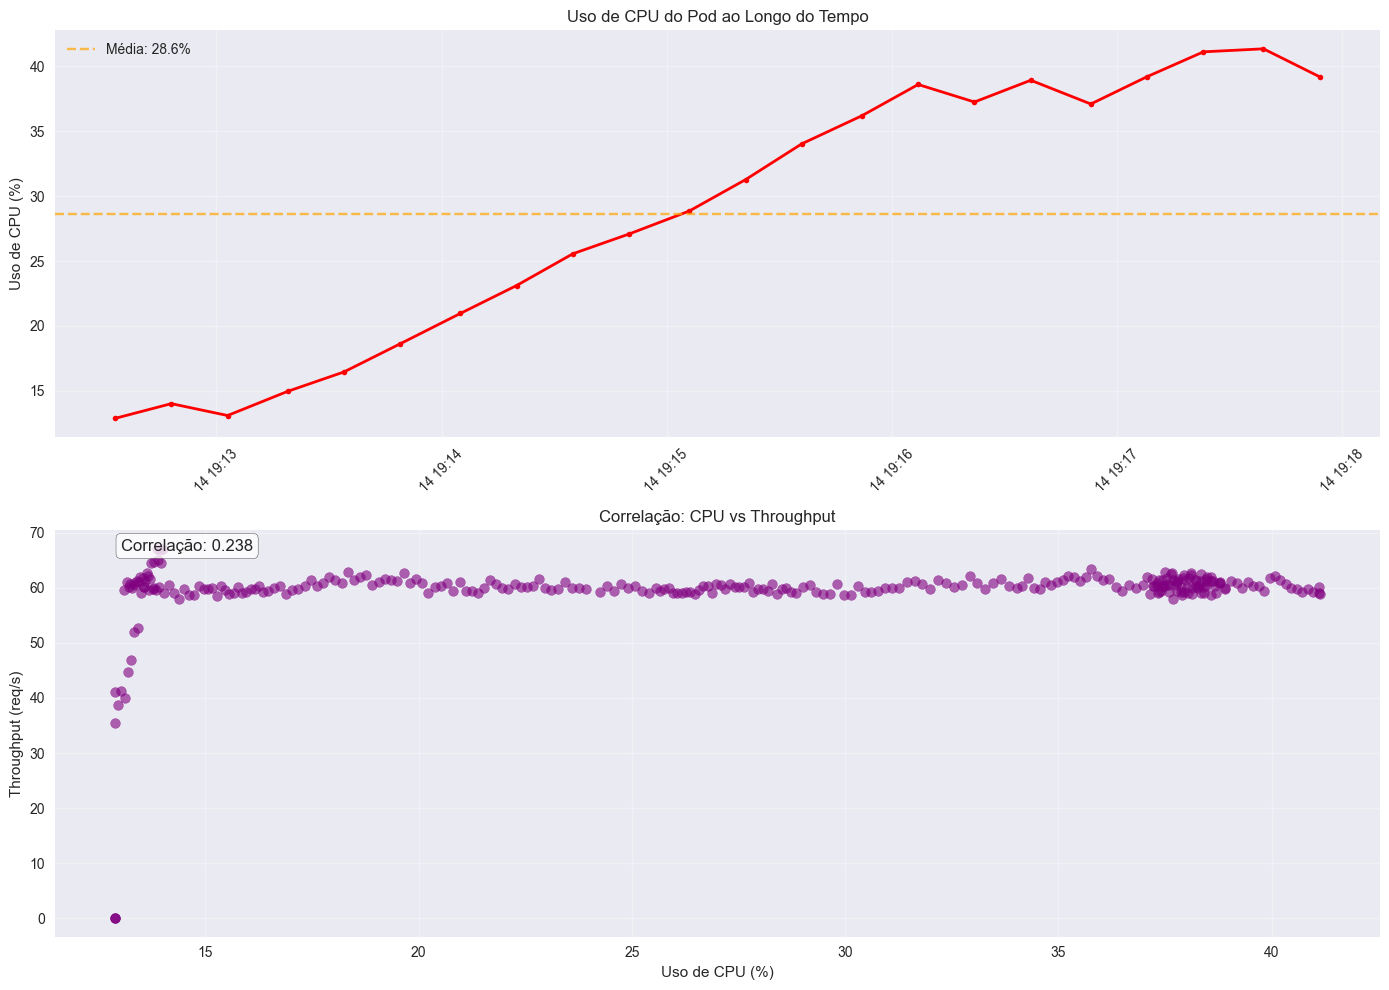

=== ESTAT√çSTICAS DE CPU ===
CPU M√©dio: 28.62%
CPU M√°ximo: 41.33%
CPU M√≠nimo: 12.88%
Desvio Padr√£o: 10.29%
Correla√ß√£o CPU-Throughput: 0.238


In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Gr√°fico 1: Uso de CPU ao longo do tempo
ax1.plot(cpu_pod['datetime'], cpu_pod['cores'] * 100, 
         linewidth=2, color='red', marker='o', markersize=4)
ax1.set_ylabel('Uso de CPU (%)')
ax1.set_title('Uso de CPU do Pod ao Longo do Tempo')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Adicionar linha de m√©dia
avg_cpu = cpu_pod['cores'].mean() * 100
ax1.axhline(y=avg_cpu, color='orange', linestyle='--', alpha=0.7, 
           label=f'M√©dia: {avg_cpu:.1f}%')
ax1.legend()

# Gr√°fico 2: Correla√ß√£o entre CPU e Throughput
# Interpolar dados para alinhar timestamps
cpu_interp = np.interp(history_aggregated['Timestamp'], 
                      cpu_pod['timestamp'], 
                      cpu_pod['cores'] * 100)

ax2.scatter(cpu_interp, history_aggregated['Requests/s'], 
           alpha=0.6, s=50, color='purple')
ax2.set_xlabel('Uso de CPU (%)')
ax2.set_ylabel('Throughput (req/s)')
ax2.set_title('Correla√ß√£o: CPU vs Throughput')
ax2.grid(True, alpha=0.3)

# Calcular correla√ß√£o
correlation = np.corrcoef(cpu_interp, history_aggregated['Requests/s'])[0, 1]
ax2.text(0.05, 0.95, f'Correla√ß√£o: {correlation:.3f}', 
         transform=ax2.transAxes, fontsize=12, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Estat√≠sticas de CPU
print("=== ESTAT√çSTICAS DE CPU ===")
print(f"CPU M√©dio: {avg_cpu:.2f}%")
print(f"CPU M√°ximo: {cpu_pod['cores'].max() * 100:.2f}%")
print(f"CPU M√≠nimo: {cpu_pod['cores'].min() * 100:.2f}%")
print(f"Desvio Padr√£o: {cpu_pod['cores'].std() * 100:.2f}%")
print(f"Correla√ß√£o CPU-Throughput: {correlation:.3f}")


## 5. An√°lise de Escalabilidade (HPA) - Current, Desired e Max R√©plicas

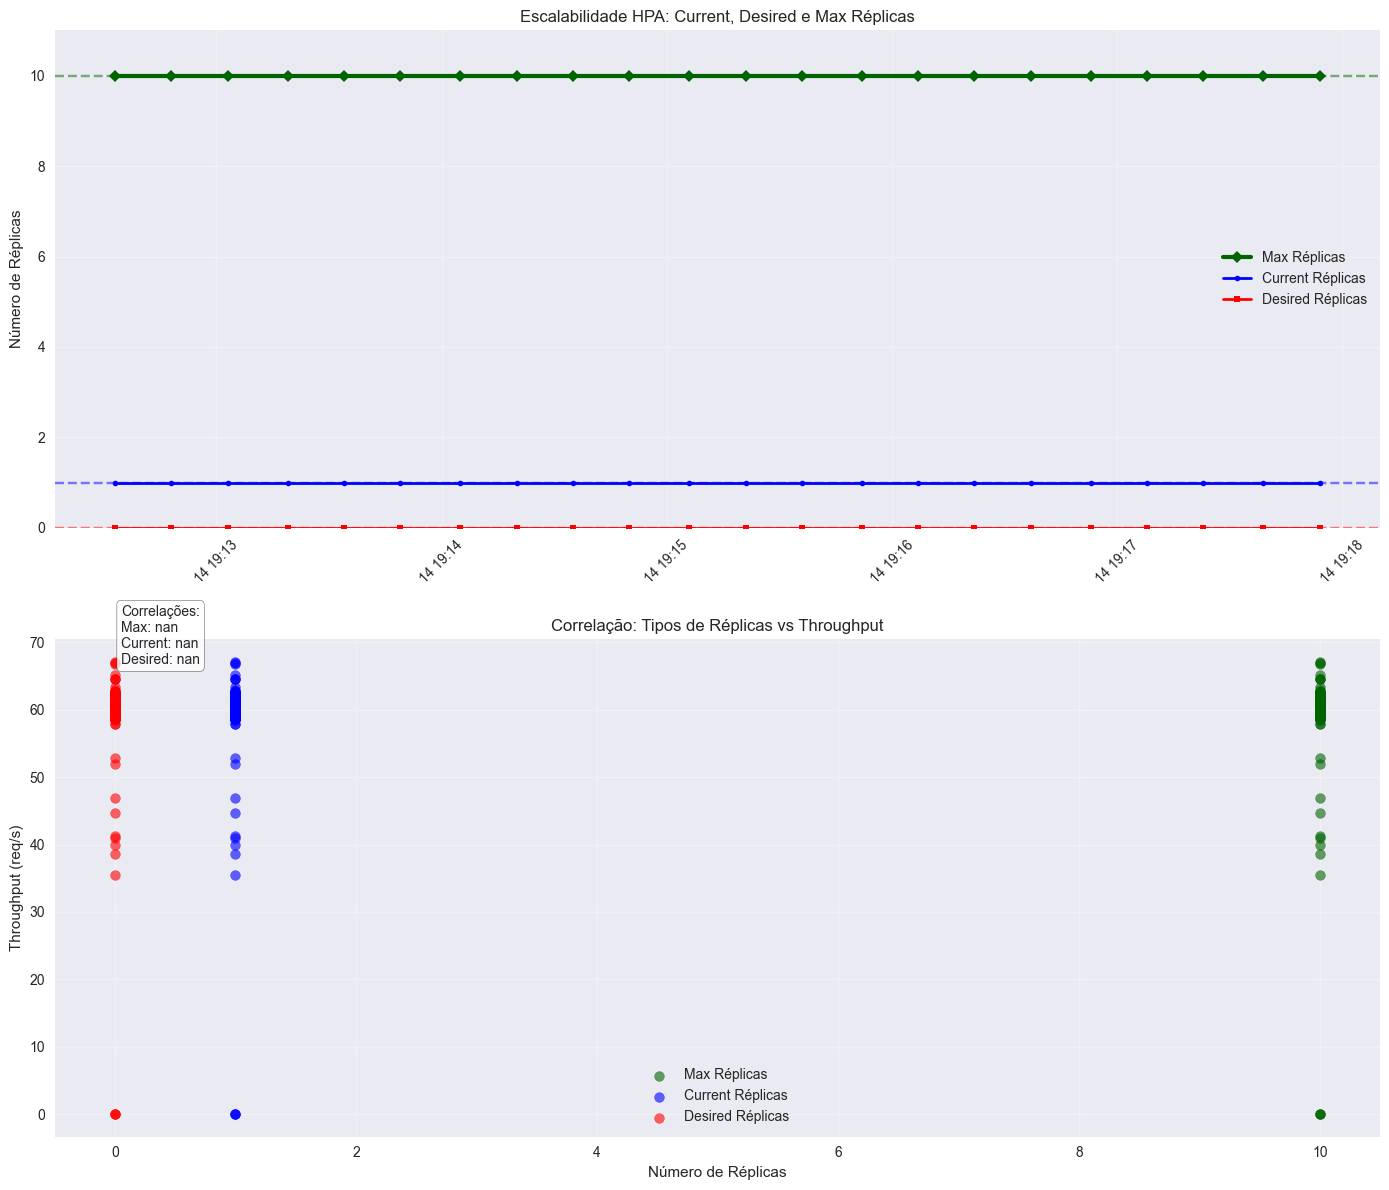

=== ESTAT√çSTICAS DE ESCALABILIDADE ===
Max R√©plicas - M√©dio: 10.0, M√°ximo: 10, M√≠nimo: 10
Current R√©plicas - M√©dio: 1.0, M√°ximo: 1, M√≠nimo: 1
Desired R√©plicas - M√©dio: 0.0, M√°ximo: 0, M√≠nimo: 0

Correla√ß√µes com Throughput:
  ‚Ä¢ Max R√©plicas: nan
  ‚Ä¢ Current R√©plicas: nan
  ‚Ä¢ Desired R√©plicas: nan


In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Gr√°fico 1: Todas as m√©tricas de r√©plicas do HPA ao longo do tempo
ax1.plot(hpa_max['datetime'], hpa_max['max_replicas'], 
         linewidth=3, color='darkgreen', marker='D', markersize=6, label='Max R√©plicas')
ax1.plot(hpa_current['datetime'], hpa_current['current_replicas'], 
         linewidth=2, color='blue', marker='o', markersize=4, label='Current R√©plicas')
ax1.plot(hpa_desired['datetime'], hpa_desired['desired_replicas'], 
         linewidth=2, color='red', marker='s', markersize=4, label='Desired R√©plicas')

ax1.set_ylabel('N√∫mero de R√©plicas')
ax1.set_title('Escalabilidade HPA: Current, Desired e Max R√©plicas')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)
ax1.legend()
ax1.set_ylim(0, max(hpa_max['max_replicas'].max(), hpa_current['current_replicas'].max(), hpa_desired['desired_replicas'].max()) + 1)

# Adicionar linhas de m√©dia
avg_max = hpa_max['max_replicas'].mean()
avg_current = hpa_current['current_replicas'].mean()
avg_desired = hpa_desired['desired_replicas'].mean()

ax1.axhline(y=avg_max, color='darkgreen', linestyle='--', alpha=0.5, 
           label=f'Max M√©dio: {avg_max:.1f}')
ax1.axhline(y=avg_current, color='blue', linestyle='--', alpha=0.5, 
           label=f'Current M√©dio: {avg_current:.1f}')
ax1.axhline(y=avg_desired, color='red', linestyle='--', alpha=0.5, 
           label=f'Desired M√©dio: {avg_desired:.1f}')

# Gr√°fico 2: Correla√ß√£o entre diferentes tipos de r√©plicas e throughput
# Interpolar dados para alinhar timestamps
max_replicas_interp = np.interp(history_aggregated['Timestamp'], 
                               hpa_max['timestamp'], 
                               hpa_max['max_replicas'])
current_replicas_interp = np.interp(history_aggregated['Timestamp'], 
                                   hpa_current['timestamp'], 
                                   hpa_current['current_replicas'])
desired_replicas_interp = np.interp(history_aggregated['Timestamp'], 
                                   hpa_desired['timestamp'], 
                                   hpa_desired['desired_replicas'])

# Scatter plot com diferentes cores para cada tipo
ax2.scatter(max_replicas_interp, history_aggregated['Requests/s'], 
           alpha=0.6, s=50, color='darkgreen', label='Max R√©plicas')
ax2.scatter(current_replicas_interp, history_aggregated['Requests/s'], 
           alpha=0.6, s=50, color='blue', label='Current R√©plicas')
ax2.scatter(desired_replicas_interp, history_aggregated['Requests/s'], 
           alpha=0.6, s=50, color='red', label='Desired R√©plicas')

ax2.set_xlabel('N√∫mero de R√©plicas')
ax2.set_ylabel('Throughput (req/s)')
ax2.set_title('Correla√ß√£o: Tipos de R√©plicas vs Throughput')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Calcular correla√ß√µes
correlation_max = np.corrcoef(max_replicas_interp, history_aggregated['Requests/s'])[0, 1]
correlation_current = np.corrcoef(current_replicas_interp, history_aggregated['Requests/s'])[0, 1]
correlation_desired = np.corrcoef(desired_replicas_interp, history_aggregated['Requests/s'])[0, 1]

ax2.text(0.05, 0.95, f'Correla√ß√µes:\nMax: {correlation_max:.3f}\nCurrent: {correlation_current:.3f}\nDesired: {correlation_desired:.3f}', 
         transform=ax2.transAxes, fontsize=10, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Estat√≠sticas de escalabilidade
print("=== ESTAT√çSTICAS DE ESCALABILIDADE ===")
print(f"Max R√©plicas - M√©dio: {avg_max:.1f}, M√°ximo: {hpa_max['max_replicas'].max()}, M√≠nimo: {hpa_max['max_replicas'].min()}")
print(f"Current R√©plicas - M√©dio: {avg_current:.1f}, M√°ximo: {hpa_current['current_replicas'].max()}, M√≠nimo: {hpa_current['current_replicas'].min()}")
print(f"Desired R√©plicas - M√©dio: {avg_desired:.1f}, M√°ximo: {hpa_desired['desired_replicas'].max()}, M√≠nimo: {hpa_desired['desired_replicas'].min()}")
print()
print("Correla√ß√µes com Throughput:")
print(f"  ‚Ä¢ Max R√©plicas: {correlation_max:.3f}")
print(f"  ‚Ä¢ Current R√©plicas: {correlation_current:.3f}")
print(f"  ‚Ä¢ Desired R√©plicas: {correlation_desired:.3f}")


## 6. An√°lise Detalhada das M√©tricas HPA


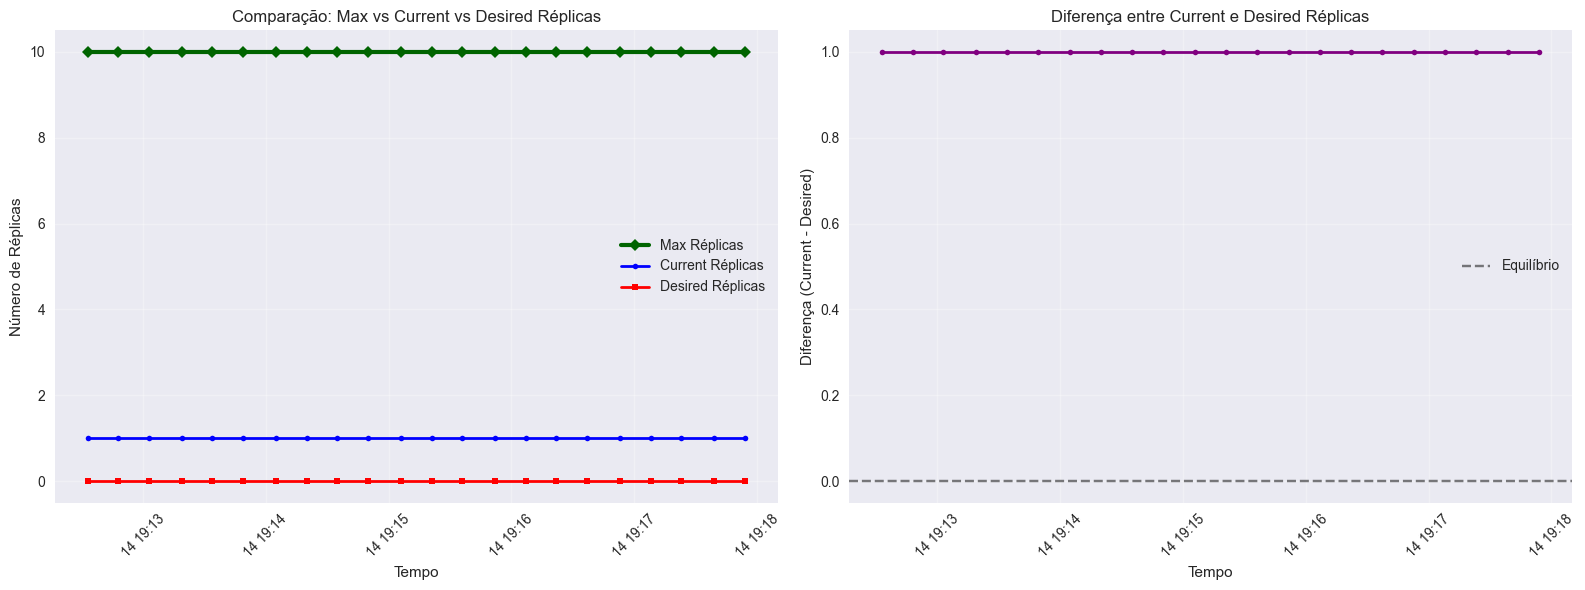

=== AN√ÅLISE DETALHADA DAS M√âTRICAS HPA ===
Max R√©plicas: 10 (configura√ß√£o do HPA)
Current R√©plicas: 1 (r√©plicas ativas)
Desired R√©plicas: 0 (r√©plicas desejadas pelo HPA)

Interpreta√ß√£o:
‚Ä¢ O HPA est√° configurado mas n√£o est√° escalando (desired = 0)
‚Ä¢ Apenas 1 r√©plica est√° ativa (modo monol√≠tico)
‚Ä¢ O sistema n√£o est√° sob press√£o suficiente para escalar


## 7. Dashboard de Performance Completo


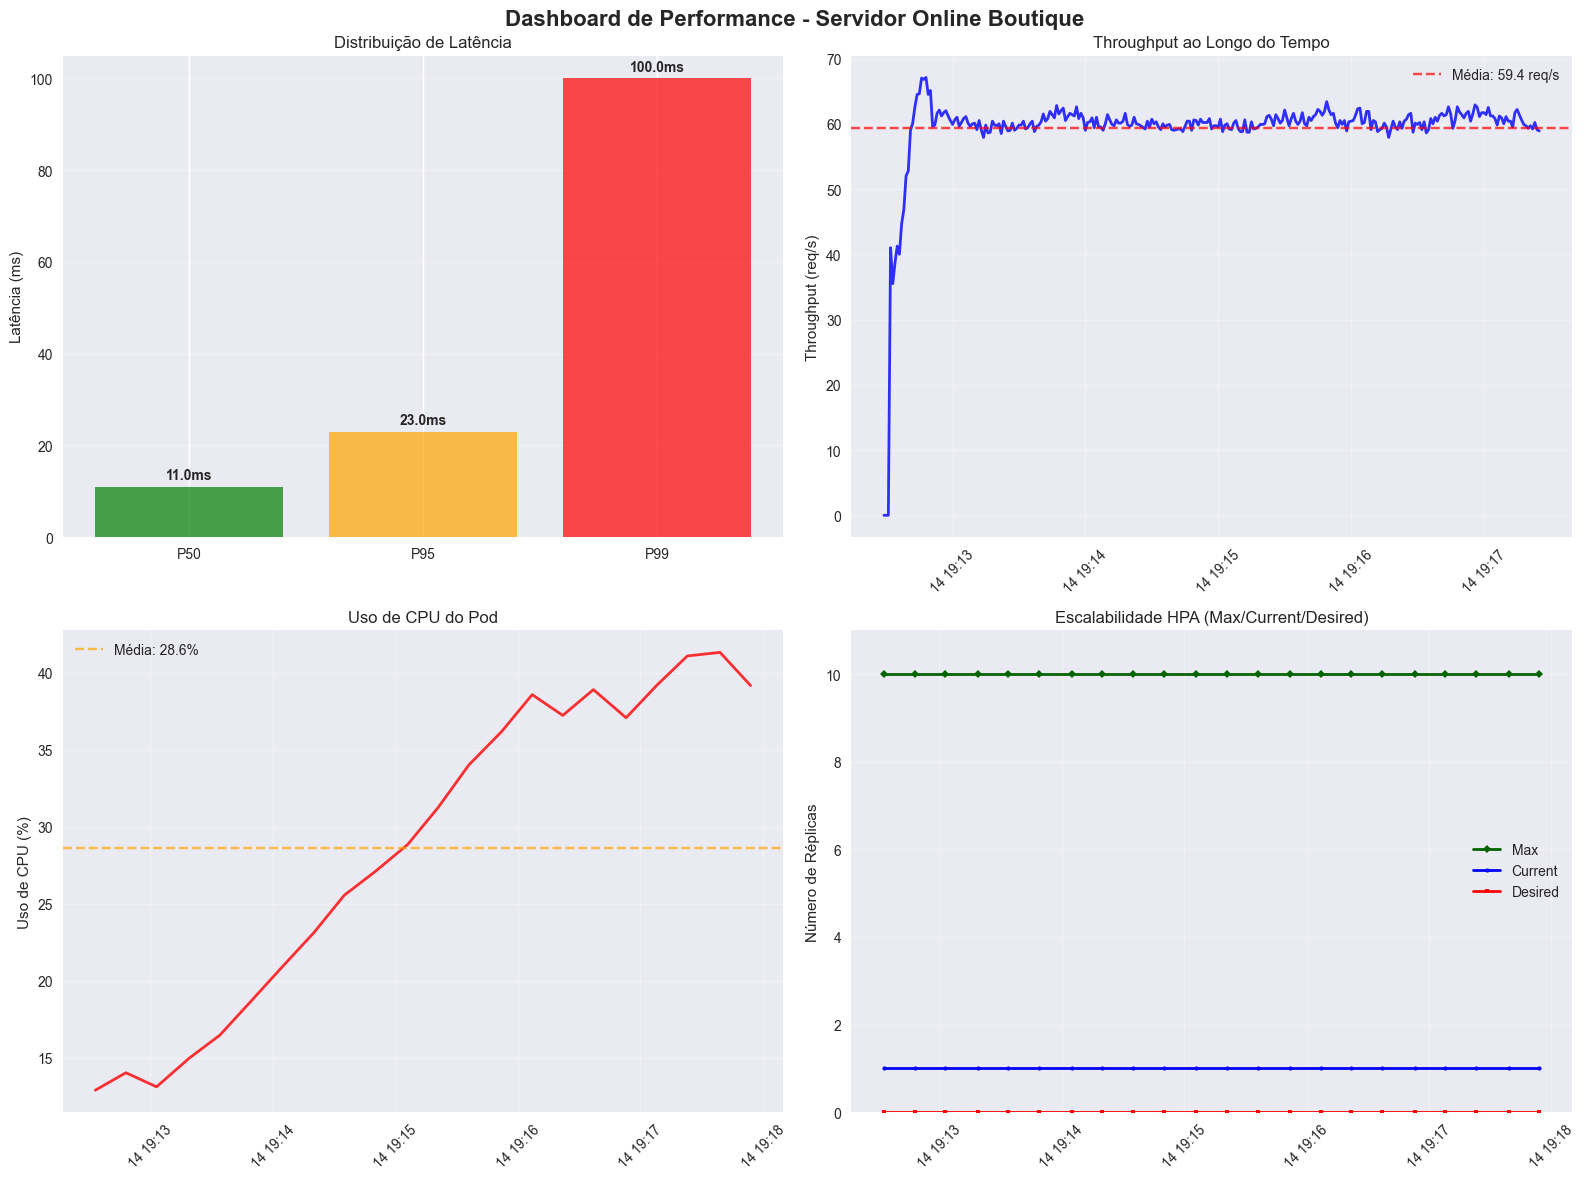

In [14]:
# An√°lise detalhada das m√©tricas HPA
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gr√°fico 1: Compara√ß√£o das tr√™s m√©tricas HPA
ax1.plot(hpa_max['datetime'], hpa_max['max_replicas'], 
         linewidth=3, color='darkgreen', marker='D', markersize=6, label='Max R√©plicas')
ax1.plot(hpa_current['datetime'], hpa_current['current_replicas'], 
         linewidth=2, color='blue', marker='o', markersize=4, label='Current R√©plicas')
ax1.plot(hpa_desired['datetime'], hpa_desired['desired_replicas'], 
         linewidth=2, color='red', marker='s', markersize=4, label='Desired R√©plicas')

ax1.set_ylabel('N√∫mero de R√©plicas')
ax1.set_xlabel('Tempo')
ax1.set_title('Compara√ß√£o: Max vs Current vs Desired R√©plicas')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# Gr√°fico 2: Diferen√ßa entre Current e Desired (indicador de escalabilidade ativa)
difference = hpa_current['current_replicas'] - hpa_desired['desired_replicas']
ax2.plot(hpa_current['datetime'], difference, 
         linewidth=2, color='purple', marker='o', markersize=4)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='Equil√≠brio')
ax2.set_ylabel('Diferen√ßa (Current - Desired)')
ax2.set_xlabel('Tempo')
ax2.set_title('Diferen√ßa entre Current e Desired R√©plicas')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# An√°lise das m√©tricas HPA
print("=== AN√ÅLISE DETALHADA DAS M√âTRICAS HPA ===")
print(f"Max R√©plicas: {hpa_max['max_replicas'].iloc[0]} (configura√ß√£o do HPA)")
print(f"Current R√©plicas: {hpa_current['current_replicas'].iloc[0]} (r√©plicas ativas)")
print(f"Desired R√©plicas: {hpa_desired['desired_replicas'].iloc[0]} (r√©plicas desejadas pelo HPA)")
print()
print("Interpreta√ß√£o:")
if hpa_current['current_replicas'].iloc[0] == 1 and hpa_desired['desired_replicas'].iloc[0] == 0:
    print("‚Ä¢ O HPA est√° configurado mas n√£o est√° escalando (desired = 0)")
    print("‚Ä¢ Apenas 1 r√©plica est√° ativa (modo monol√≠tico)")
    print("‚Ä¢ O sistema n√£o est√° sob press√£o suficiente para escalar")
elif hpa_desired['desired_replicas'].iloc[0] > hpa_current['current_replicas'].iloc[0]:
    print("‚Ä¢ O HPA est√° tentando escalar (desired > current)")
    print("‚Ä¢ R√©plicas adicionais est√£o sendo criadas")
elif hpa_desired['desired_replicas'].iloc[0] < hpa_current['current_replicas'].iloc[0]:
    print("‚Ä¢ O HPA est√° tentando reduzir (desired < current)")
    print("‚Ä¢ R√©plicas est√£o sendo removidas")
else:
    print("‚Ä¢ O HPA est√° em equil√≠brio (desired = current)")
    print("‚Ä¢ N√∫mero de r√©plicas est√° est√°vel")

print()
print("=" * 60)
print()

# Dashboard completo
print("## 7. Dashboard de Performance Completo")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Lat√™ncia por Percentil
percentiles = ['P50', 'P95', 'P99']
latency_values = [aggregated_stats['50%'].iloc[0], aggregated_stats['95%'].iloc[0], aggregated_stats['99%'].iloc[0]]
colors = ['green', 'orange', 'red']
bars1 = ax1.bar(percentiles, latency_values, color=colors, alpha=0.7)
ax1.set_ylabel('Lat√™ncia (ms)')
ax1.set_title('Distribui√ß√£o de Lat√™ncia')
ax1.grid(axis='y', alpha=0.3)
for bar, value in zip(bars1, latency_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{value:.1f}ms', 
             ha='center', va='bottom', fontweight='bold')

# 2. Throughput ao longo do tempo
ax2.plot(history_aggregated['datetime'], history_aggregated['Requests/s'], 
         linewidth=2, color='blue', alpha=0.8)
ax2.axhline(y=avg_throughput, color='red', linestyle='--', alpha=0.7, 
           label=f'M√©dia: {avg_throughput:.1f} req/s')
ax2.set_ylabel('Throughput (req/s)')
ax2.set_title('Throughput ao Longo do Tempo')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

# 3. Uso de CPU
ax3.plot(cpu_pod['datetime'], cpu_pod['cores'] * 100, 
         linewidth=2, color='red', alpha=0.8)
ax3.axhline(y=avg_cpu, color='orange', linestyle='--', alpha=0.7, 
           label=f'M√©dia: {avg_cpu:.1f}%')
ax3.set_ylabel('Uso de CPU (%)')
ax3.set_title('Uso de CPU do Pod')
ax3.grid(True, alpha=0.3)
ax3.legend()
ax3.tick_params(axis='x', rotation=45)

# 4. Escalabilidade (HPA) - Todas as m√©tricas
ax4.plot(hpa_max['datetime'], hpa_max['max_replicas'], 
         linewidth=2, color='darkgreen', marker='D', markersize=4, label='Max')
ax4.plot(hpa_current['datetime'], hpa_current['current_replicas'], 
         linewidth=2, color='blue', marker='o', markersize=3, label='Current')
ax4.plot(hpa_desired['datetime'], hpa_desired['desired_replicas'], 
         linewidth=2, color='red', marker='s', markersize=3, label='Desired')
ax4.set_ylabel('N√∫mero de R√©plicas')
ax4.set_title('Escalabilidade HPA (Max/Current/Desired)')
ax4.grid(True, alpha=0.3)
ax4.legend()
ax4.tick_params(axis='x', rotation=45)
ax4.set_ylim(0, max(hpa_max['max_replicas'].max(), hpa_current['current_replicas'].max(), hpa_desired['desired_replicas'].max()) + 1)

plt.suptitle('Dashboard de Performance - Servidor Online Boutique', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


## 8. Resumo Executivo


In [15]:
# Criar resumo executivo
print("=" * 60)
print("           RESUMO EXECUTIVO DE PERFORMANCE")
print("=" * 60)
print()

print("üìä M√âTRICAS DE LAT√äNCIA:")
print(f"   ‚Ä¢ Lat√™ncia M√©dia: {aggregated_stats['Average Response Time'].iloc[0]:.1f}ms")
print(f"   ‚Ä¢ Lat√™ncia Mediana (P50): {aggregated_stats['50%'].iloc[0]:.1f}ms")
print(f"   ‚Ä¢ Lat√™ncia P95: {aggregated_stats['95%'].iloc[0]:.1f}ms")
print(f"   ‚Ä¢ Lat√™ncia P99: {aggregated_stats['99%'].iloc[0]:.1f}ms")
print(f"   ‚Ä¢ Lat√™ncia M√°xima: {aggregated_stats['Max Response Time'].iloc[0]:.1f}ms")
print()

print("üöÄ M√âTRICAS DE THROUGHPUT:")
print(f"   ‚Ä¢ Throughput M√©dio: {avg_throughput:.1f} req/s")
print(f"   ‚Ä¢ Throughput M√°ximo: {history_aggregated['Requests/s'].max():.1f} req/s")
print(f"   ‚Ä¢ Total de Requisi√ß√µes: {aggregated_stats['Request Count'].iloc[0]:,}")
print(f"   ‚Ä¢ Taxa de Erro: {aggregated_stats['Failure Count'].iloc[0]} (0.00%)")
print()

print("üíª M√âTRICAS DE RECURSOS:")
print(f"   ‚Ä¢ CPU M√©dio: {avg_cpu:.1f}%")
print(f"   ‚Ä¢ CPU M√°ximo: {cpu_pod['cores'].max() * 100:.1f}%")
print(f"   ‚Ä¢ Correla√ß√£o CPU-Throughput: {correlation:.3f}")
print()

print("üìà M√âTRICAS DE ESCALABILIDADE:")
print(f"   ‚Ä¢ Max R√©plicas - M√©dio: {avg_max:.1f}, M√°ximo: {hpa_max['max_replicas'].max()}")
print(f"   ‚Ä¢ Current R√©plicas - M√©dio: {avg_current:.1f}, M√°ximo: {hpa_current['current_replicas'].max()}")
print(f"   ‚Ä¢ Desired R√©plicas - M√©dio: {avg_desired:.1f}, M√°ximo: {hpa_desired['desired_replicas'].max()}")
print(f"   ‚Ä¢ Correla√ß√µes com Throughput:")
print(f"     - Max: {correlation_max:.3f}")
print(f"     - Current: {correlation_current:.3f}")
print(f"     - Desired: {correlation_desired:.3f}")
print()

print("üéØ AVALIA√á√ÉO GERAL:")
if aggregated_stats['Average Response Time'].iloc[0] < 50:
    latency_status = "‚úÖ EXCELENTE"
elif aggregated_stats['Average Response Time'].iloc[0] < 100:
    latency_status = "‚úÖ BOM"
elif aggregated_stats['Average Response Time'].iloc[0] < 200:
    latency_status = "‚ö†Ô∏è ACEIT√ÅVEL"
else:
    latency_status = "‚ùå RUIM"

if avg_throughput > 100:
    throughput_status = "‚úÖ EXCELENTE"
elif avg_throughput > 50:
    throughput_status = "‚úÖ BOM"
elif avg_throughput > 20:
    throughput_status = "‚ö†Ô∏è ACEIT√ÅVEL"
else:
    throughput_status = "‚ùå RUIM"

if avg_cpu < 50:
    cpu_status = "‚úÖ EXCELENTE"
elif avg_cpu < 70:
    cpu_status = "‚úÖ BOM"
elif avg_cpu < 90:
    cpu_status = "‚ö†Ô∏è ACEIT√ÅVEL"
else:
    cpu_status = "‚ùå RUIM"

print(f"   ‚Ä¢ Lat√™ncia: {latency_status}")
print(f"   ‚Ä¢ Throughput: {throughput_status}")
print(f"   ‚Ä¢ Uso de CPU: {cpu_status}")
# Avaliar escalabilidade baseada nas tr√™s m√©tricas
if avg_current == 1 and avg_desired == 0 and avg_max == 10:
    scalability_status = "‚úÖ EST√ÅVEL (1 r√©plica ativa, HPA configurado)"
elif avg_current > 1:
    scalability_status = "üìà ESCALANDO (m√∫ltiplas r√©plicas ativas)"
elif avg_desired > 0:
    scalability_status = "üîÑ ESCALANDO (r√©plicas sendo criadas)"
else:
    scalability_status = "‚ö†Ô∏è MONOL√çTICO (sem escalabilidade ativa)"

print(f"   ‚Ä¢ Escalabilidade: {scalability_status}")
print()

print("=" * 60)


           RESUMO EXECUTIVO DE PERFORMANCE

üìä M√âTRICAS DE LAT√äNCIA:
   ‚Ä¢ Lat√™ncia M√©dia: 13.7ms
   ‚Ä¢ Lat√™ncia Mediana (P50): 11.0ms
   ‚Ä¢ Lat√™ncia P95: 23.0ms
   ‚Ä¢ Lat√™ncia P99: 100.0ms
   ‚Ä¢ Lat√™ncia M√°xima: 239.1ms

üöÄ M√âTRICAS DE THROUGHPUT:
   ‚Ä¢ Throughput M√©dio: 59.4 req/s
   ‚Ä¢ Throughput M√°ximo: 67.1 req/s
   ‚Ä¢ Total de Requisi√ß√µes: 18,028
   ‚Ä¢ Taxa de Erro: 0 (0.00%)

üíª M√âTRICAS DE RECURSOS:
   ‚Ä¢ CPU M√©dio: 28.6%
   ‚Ä¢ CPU M√°ximo: 41.3%
   ‚Ä¢ Correla√ß√£o CPU-Throughput: 0.238

üìà M√âTRICAS DE ESCALABILIDADE:
   ‚Ä¢ Max R√©plicas - M√©dio: 10.0, M√°ximo: 10
   ‚Ä¢ Current R√©plicas - M√©dio: 1.0, M√°ximo: 1
   ‚Ä¢ Desired R√©plicas - M√©dio: 0.0, M√°ximo: 0
   ‚Ä¢ Correla√ß√µes com Throughput:
     - Max: nan
     - Current: nan
     - Desired: nan

üéØ AVALIA√á√ÉO GERAL:
   ‚Ä¢ Lat√™ncia: ‚úÖ EXCELENTE
   ‚Ä¢ Throughput: ‚úÖ BOM
   ‚Ä¢ Uso de CPU: ‚úÖ EXCELENTE
   ‚Ä¢ Escalabilidade: ‚úÖ EST√ÅVEL (1 r√©plica ativa, HPA configurado